                                         Ele-492
                                          HW-2
I pledge that I have not received or given any aid in this homework. All the work
presented below is my own work.
Name & surname:Furkan ÇÖZELİ
Number:21427837

In [1]:
import cv2
import numpy as np
from scipy import ndimage
import os

In [2]:
def mapping(match):
    #I create a map of the match operation with the mapping function.
    matchRow, matchCol = match.shape
    matchMin, matchMax = np.min(match), np.max(match)
    mapping = np.zeros((matchRow, matchCol),np.uint8)

    i=j=0
    while i < matchRow:
        while j < matchCol:
            #I am making the match range 0-255
            #and assign it to the variable named mapping.
            mapping[i,j] = int((match[i,j]-matchMin)*255/(matchMax-matchMin)) 
            j += 1
        j = 0
        i += 1

    return mapping

Here I show the matching process as an image in grayscale format. For this, I adapt the match values to the 0-255 range.
In this way, I can easily observe the places where the match is high.

In [3]:
def findPoints(match, threshold):
    #Here I identify all the points where the match is high.
    points = []
    #I am doing the sorting process.
    #then reverse the result of sort process. / np.flipud(...)
    matchSort = np.sort(match, axis = None)
    matchSort = np.flipud(matchSort)
    
    loc = np.where( matchSort >= threshold)
    lenLoc = len(loc[0])
    
    i=0
    while i < lenLoc:
        newLoc = np.where(match == matchSort[i])
        for pt in zip(*newLoc[::-1]):
            #the detected points are added to the points array.
            points.append([pt[0],pt[1]])
        i += 1

    return points

In the findPoints function, I detect all points where the match is high. Here I make use of sorting and inversion.

In [4]:
def eliminateExcessPoints(points, tempRow, tempCol):
    #Here, matches that are very close to each other are checked.
    #Among them, the most suitable matches are taken and the others are eliminated.
    lenPoints = len(points)
    finalPoints = []
    i = 0
    while i < lenPoints:
        if len(finalPoints) == 0:
            finalPoints.append(points[i])
        
        j=0
        outSide = True
        #If the checked point is close to the previously detected points, it is eliminated,
        #otherwise it is added to the finalpoints array.
        while j < len(finalPoints):
            if abs(points[i][0]-finalPoints[j][0]) < tempCol  and  abs(points[i][1]-finalPoints[j][1]) < tempRow:
                outSide = False
            j += 1
                      
        if outSide:
            finalPoints.append(points[i])
        
        i += 1

    return finalPoints

In this function, I eliminate points that are redundant. Because these points cause 1 component to be found too many times. With this function, I avoid this problem.

In [5]:
def drawRectangle(img, finalPoints, color, tempCol, tempRow):
    #Rectangles are drawn according to the detected points.
    i = 0
    while i < len(finalPoints):
        cv2.rectangle(img, (finalPoints[i][0], finalPoints[i][1]),
                      (finalPoints[i][0]+tempCol, finalPoints[i][1]+tempRow), color, 2)
        i += 1

    return img

Once you have the correct points, a rectangle is drawn around the components here.

In [6]:
def readImagesFromFile(path):
    images = []
    for imageName in os.listdir(path):
        img = cv2.imread(os.path.join(path,imageName))
        if img is not None:
            images.append([img,imageName])

    return images

This function allows reading all photos in 1 folder.

In [7]:
def rotate(image, template):
    #This function is suitable for images with rotated rotation.
    #Here it is determined how many degrees the image is rotated.
    i = deg = maxValue = 0
    
    while i < 360:
        img = image.copy()
        rot = ndimage.rotate(img, i)
    
        match = cv2.matchTemplate(rot, template, cv2.TM_CCOEFF_NORMED)
        matchMax = np.max(match)
        if matchMax > maxValue:
            maxValue = matchMax
            deg = i    
        i += 1
    rotateImg = ndimage.rotate(image, deg)

    return rotateImg, deg

With this function, we analyze the template image whose rotation has been changed. Checking match status for all ranks from 0 to 359. The highest match at the correct degree is achieved. This is checked in this function.

In [8]:
def scale(image, template):
    #This function is suitable for resized images.
    #Here the rate of change of the image is determined.
    #I check the resize process in the range of 0.5-2. I start at 0.5 and increment 0.1 for each step.
    row, col, ch = image.shape
    i = rate = maxValue = 0

    while i < 16:
        img = image.copy()
        resized = cv2.resize(img, (int(col*(0.5+i*0.1)),int(row*(0.5+i*0.1))), interpolation = cv2.INTER_AREA)
        match = cv2.matchTemplate(resized, template, cv2.TM_CCOEFF_NORMED)
        matchMax = np.max(match)
        if matchMax > maxValue:
            maxValue = matchMax
            rate = 0.5+i*0.1
        i += 1
    resized = cv2.resize(image, (int(col*rate),int(row*rate)), interpolation = cv2.INTER_AREA)

    return resized, rate

Here we analyze the template image whose size has been changed. I control the size change ratio between 0.5 and 2. the highest match will be in the correct ratio. I'm trying to find this ratio in this function. I can make the control process at a higher range or more detailed but this will make the process take longer. I set a small interval to keep the process short.

In [9]:
def scaleAndRotate(image, template):
    #This function is suitable for images that are both sized and rotated.
    #Here it is determined how many degrees the image is rotated and the rate of change of the image. 
    row, col, ch = image.shape
    #info[rate of resize, rotation degree, maximum value of match process]
    i, j, info = 0, -45, [0,0,0]
    
    while i<16:
        img = image.copy()
        img = cv2.resize(img, (int(col*(0.5+0.1*i)),int(row*(0.5+0.1*i))), interpolation = cv2.INTER_AREA)

        while j < 46:
            rot = ndimage.rotate(img, j)
            match = cv2.matchTemplate(rot, template, cv2.TM_CCOEFF_NORMED)
            matchMax = np.max(match)
            
            if matchMax > info[2]:
                info = [0.5+0.1*i,j,matchMax]
            
            j += 1
        if info[2] > 0.9:
            break
        
        j = -45
        i += 1
        
    return info

Here I am doing the process of finding the image whose size and rotation have been changed. For this, I change the size first. Then I do a rotation check for all dimensions. This process takes a lot of time. It took about 30 minutes when I first did it. So I made the rotation range from -45 to +45. In addition, if the match is greater than 90%, I finish the transaction.

We will see the use of functions written in the following sections.

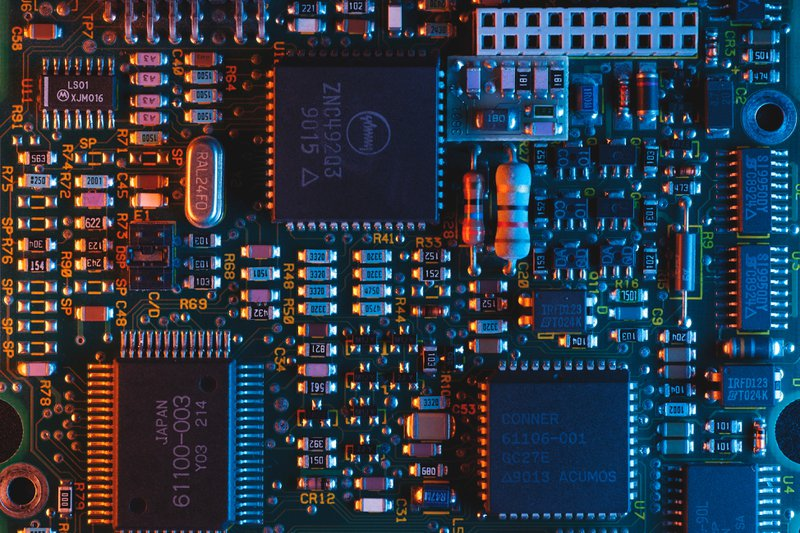

This image is full image. I am getting the components from this view. After the components are detected, I will not add the original version. You can check it out here.

In [10]:
# 1 image(same size)
img = cv2.imread("images/fullImage.jpg")
template = cv2.imread("images/same/same.jpg")
tempRow, tempCol, ch = template.shape

threshold = 0.6
color = (0,0,255)

match = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
mapImg = mapping(match)
points = findPoints(match, threshold)
finalPoints = eliminateExcessPoints(points, tempRow, tempCol)
img = drawRectangle(img, finalPoints, color, tempCol, tempRow)

cv2.imwrite("save/same size 1 component.jpg",img)
cv2.imwrite("save/map image.jpg",mapImg)
cv2.imshow("img", img)
cv2.imshow("mapImg",mapImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

Here, the image that has not been changed is detected. One template photo is used. The mapping image is also checked while detecting the template image.

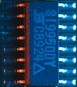

template image

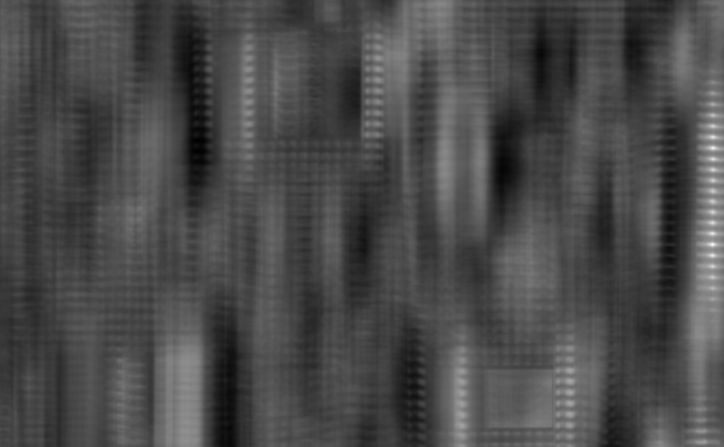

The higher the match rate of the matching regions, the whiter it will be. It seems that there is more to match on the right.

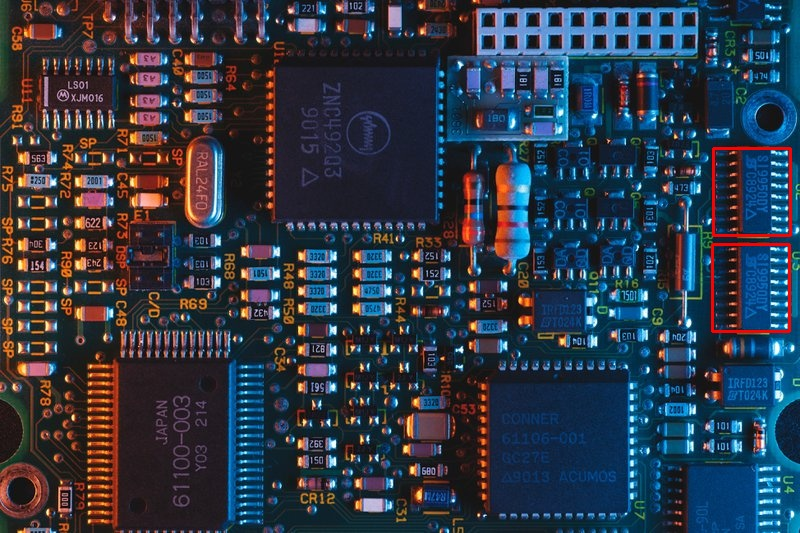

In [11]:
# +1 images(same size)
img = cv2.imread("images/fullImage.jpg")
path = "images/same"
images = readImagesFromFile(path)
i, threshold, color = 0, 0.8, (255,255,0)

while i < len(images):
    if "same.jpg" == images[i][1]:
        threshold = 0.7
        color = (255,0,0)
    elif "same2.jpg" == images[i][1]:
        threshold = 0.85
        color = (0,255,0)
    elif "same3.jpg" == images[i][1]:
        threshold = 0.6
        color = (0,0,255)

    template = images[i][0]
    tempRow, tempCol, tempCh = template.shape

    match = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)

    points = findPoints(match, threshold)
    finalPoints = eliminateExcessPoints(points, tempRow, tempCol)

    img = drawRectangle(img, finalPoints, color, tempCol, tempRow)

    i += 1

cv2.imwrite("save/same size 3 component.jpg",img)
cv2.imshow("img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Detection is made for more than 1 template image. Threshold and color are set by default. If we want to change the threshold and color especially for a photo, we can do that.

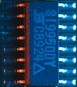

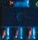

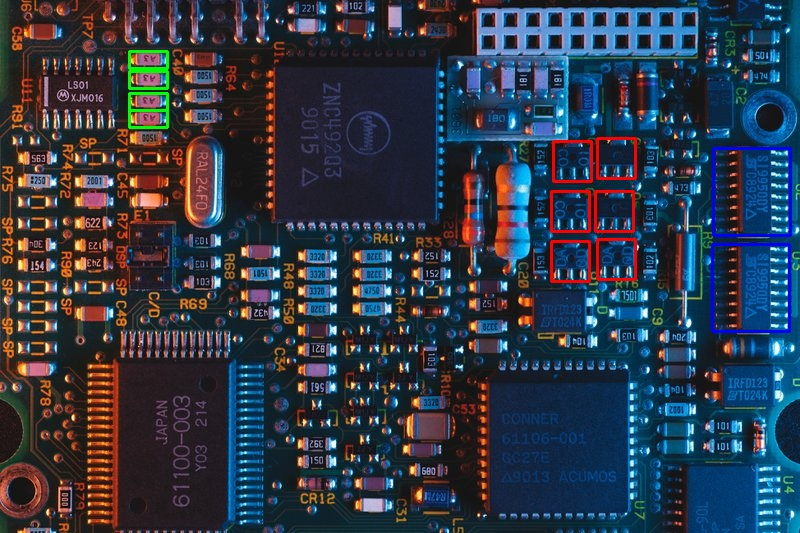

In [12]:
# 1 image(rotate)
img = cv2.imread("images/fullImage.jpg")
imgRow, imgCol, ch = img.shape
image = img.copy()
template = cv2.imread("images/rotatecw20.jpg")
tempRow, tempCol, tempCh = template.shape

color = (0,255,0)

rotateImg, deg = rotate(img, template)

match = cv2.matchTemplate(rotateImg,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
points = findPoints(match, threshold)
finalPoints = eliminateExcessPoints(points, tempRow, tempCol)

rotateCH = ndimage.rotate(image, deg)
drawCH = drawRectangle(rotateCH, finalPoints, color, tempCol, tempRow)
rotateCH = ndimage.rotate(drawCH, 360-deg)
cv2.imwrite("save/black side.jpg",rotateCH)

rowCH, colCh, ch = rotateCH.shape

image = rotateCH[int((rowCH-imgRow)/2):int(rowCH-(rowCH-imgRow)/2), int((colCh-imgCol)/2):int(colCh-(colCh-imgCol)/2)]

cv2.imwrite("save/rotate 1 component.jpg",image)
cv2.imshow("image",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Detection of an image whose rotation has been changed. We use the rotate function we wrote here. It is necessary to change the rotation of the large image to determine how many degrees of rotation it is rotating. If we change the rotation of the template image, black areas will appear in the corners. This causes me to make the pairing process wrong. After the template is detected, the large image is corrected to the correct rotation. But after this process, black edges appear. By removing these black edges, the image is ready.

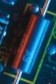

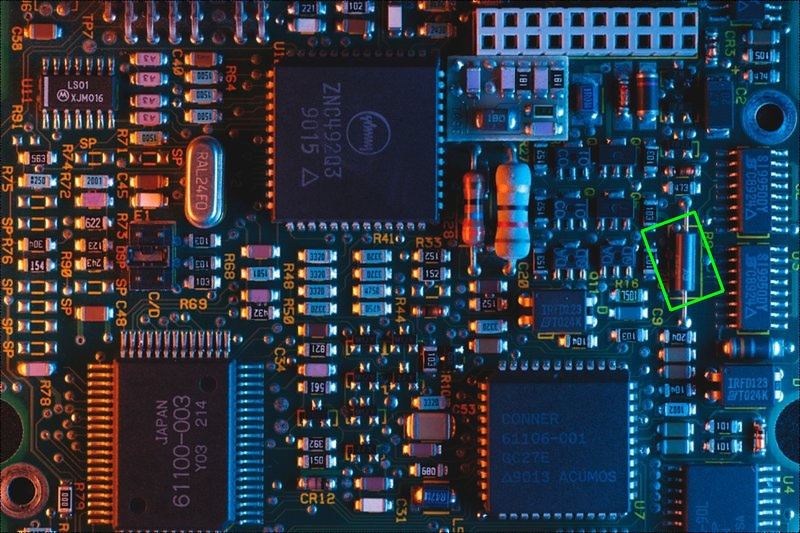

In [13]:
# +1 images(rotate)
img = cv2.imread("images/fullImage.jpg")
imgRow, imgCol, ch = img.shape
image = img.copy()

path = "images/rotate"

templates = readImagesFromFile(path)
threshold = 0.8
color = (255,255,0)
i=0

while i < len(templates):
    if "rotatecw20.jpg" == images[i][1]:
        threshold = 0.7
        color = (255,0,0)
    elif "rotateccw30.jpg" == images[i][1]:
        threshold = 0.85
        color = (0,255,0)
    elif "rotatecw45.jpg" == images[i][1]:
        threshold = 0.6
        color = (0,0,255)

    template = templates[i][0]
    tempRow, tempCol, ch = template.shape

    rotateImg, deg = rotate(img, template)

    match = cv2.matchTemplate(rotateImg,template,cv2.TM_CCOEFF_NORMED)
    points = findPoints(match, threshold)
    finalPoints = eliminateExcessPoints(points, tempRow, tempCol)

    rotateImg2 = ndimage.rotate(image, deg)
    draw = drawRectangle(rotateImg2, finalPoints, color, tempCol, tempRow)
    rotateImg3 = ndimage.rotate(draw, 360-deg)

    row, col, ch = rotateImg3.shape

    image = rotateImg3[int((row-imgRow)/2):int(row-(row-imgRow)/2), int((col-imgCol)/2):int(col-(col-imgCol)/2)]

    i += 1

cv2.imwrite("save/rotate 3 component.jpg",image)
cv2.imshow("image",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Detection of more than one image whose rotation has been changed.

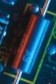

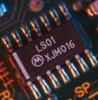

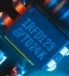

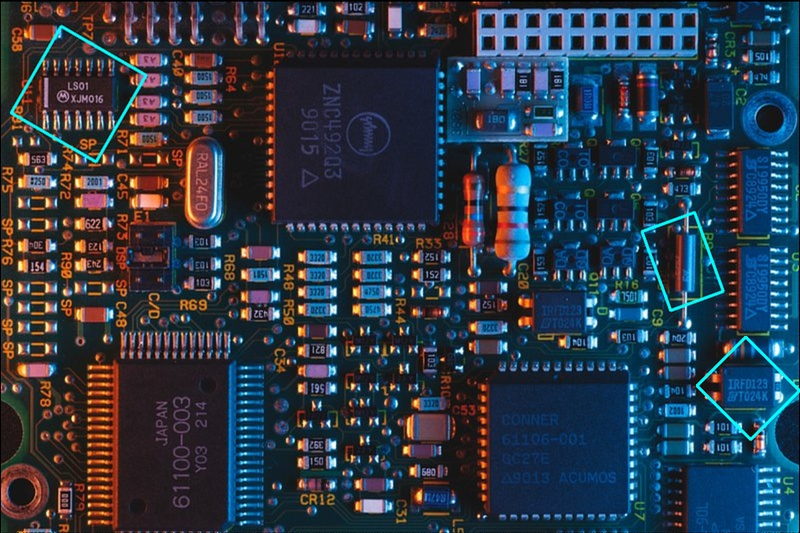

In [14]:
# 1 image(scale)
img = cv2.imread("images/fullImage.jpg")

template = cv2.imread("images/scale/scale1.8.jpg")
resized, rate = scale(img, template)

threshold = 0.7

tempRow, tempCol, ch = template.shape

match = cv2.matchTemplate(resized,template,cv2.TM_CCOEFF_NORMED)
points = findPoints(match, threshold)
finalPoints = eliminateExcessPoints(points, tempRow, tempCol)

draw = drawRectangle(resized, finalPoints, (0,0,255), tempCol, tempRow)
drawRow, drawCol, ch = draw.shape

image = cv2.resize(draw, (int(drawCol/rate),int(drawRow/rate)), interpolation = cv2.INTER_AREA)

cv2.imwrite("save/scale 1 component.jpg",image)
cv2.imshow("final",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Detection of the template image whose size has been changed. Here, too, the large image is used for detection. The losses that will occur in the template display cause greater problems. That's why the process is done without changing the size of the template image.

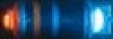

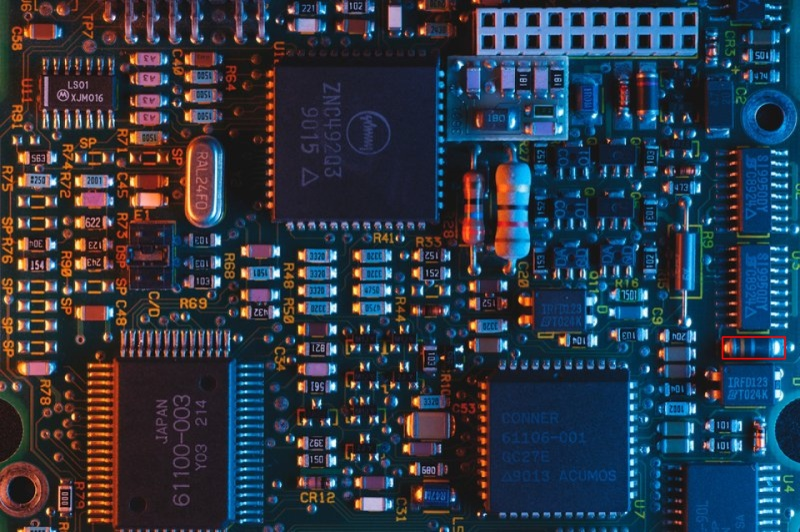

The component is on the right.

In [15]:
# +1 images(scale)
img = cv2.imread("images/fullImage.jpg")
imgRow, imgCol, ch = img.shape
image = img.copy()

path = "images/scale"

images = readImagesFromFile(path)

threshold = 0.8
color = (255,255,0)
i=0

while i < len(images):
    if "scale0.7.jpg" == images[i][1]:
        threshold = 0.85
        color = (255,0,0)
    elif "scale1.2.jpg" == images[i][1]:
        threshold = 0.75
        color = (0,255,0)
    elif "scale1.8.jpg" == images[i][1]:
        threshold = 0.9
        color = (0,0,255)

    template = images[i][0]
    tempRow, tempCol, ch = template.shape
    resized, rate = scale(img, template)
    match = cv2.matchTemplate(resized,template,cv2.TM_CCOEFF_NORMED)
    points = findPoints(match, threshold)
    finalPoints = eliminateExcessPoints(points, tempRow, tempCol)
    draw = drawRectangle(resized, finalPoints, color, tempCol, tempRow)
    drawRow, drawCol, ch = draw.shape

    img = cv2.resize(draw, (int(drawCol/rate),int(drawRow/rate)), interpolation = cv2.INTER_AREA)
    i += 1

cv2.imwrite("save/scale 3 component.jpg",img)
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Detection of more than one template image whose size has been changed.

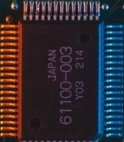

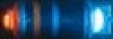

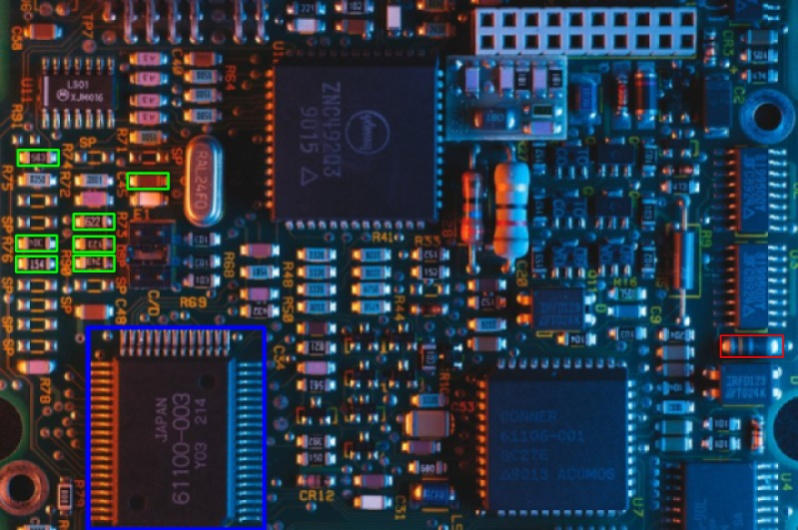

Here the image was resized and then restored. Since this process was done 3 times, there were losses in the image. By recording the coordinates when the components are detected. Then, an algorithm can be developed on how the coordinates will change when the image is restored. Using these coordinates, a rectangle can be drawn on the original image. Thus, the image is detected without deterioration.

In [16]:
# 1 image (rotate+scale)
img = cv2.imread("images/fullImage.jpg")
imgRow, imgCol, ch = img.shape

template = cv2.imread("images/rotate&scale/rotateccw13scale0.7.jpg")
tempRow, tempCol, ch = template.shape

threshold = 0.7
color = (0,255,0)

info = scaleAndRotate(img, template)

resized = cv2.resize(img, (int(imgCol*info[0]),int(imgRow*info[0])), interpolation = cv2.INTER_AREA)
resizedRow, resizedCol, ch = resized.shape

rot = ndimage.rotate(resized, info[1])

match = cv2.matchTemplate(rot, template, cv2.TM_CCOEFF_NORMED)

points = findPoints(match, threshold)
finalPoints = eliminateExcessPoints(points, tempRow, tempCol)

draw = drawRectangle(rot, finalPoints, color, tempCol, tempRow)

rotDraw = ndimage.rotate(draw, 360-info[1])
rotDrawRow, rotDrawCol, ch = rotDraw.shape


fixRot = rotDraw[int((rotDrawRow-resizedRow)/2):int(rotDrawRow-(rotDrawRow-resizedRow)/2),
                 int((rotDrawCol-resizedCol)/2):int(rotDrawCol-(rotDrawCol-resizedCol)/2)]

fixScale = cv2.resize(fixRot, (int(resizedCol/info[0]),int(resizedRow/info[0])), interpolation = cv2.INTER_AREA)

cv2.imwrite("save/rotate and scale 1 component.jpg",fixScale)
cv2.imshow("last",fixScale)
cv2.waitKey(0)
cv2.destroyAllWindows()

A template image whose size and rotation are changed is detected. In this process, I first changed the size of the large image and then changed its rotation. This is how I scanned. I made the determination with the values for which the highest match rate was found. Because of this process taking too long, I had to restrict the rotation.

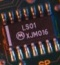

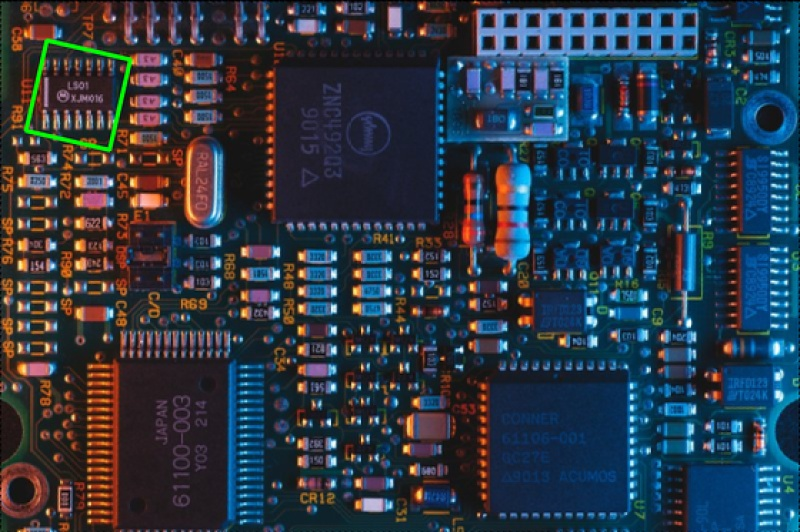